In [1]:
%matplotlib widget

In [2]:
import os
import json
import yaml
from copy import deepcopy
from multiprocessing import Pool

import pandas as pd
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits

import gPhoton as gp
from gPhoton.gphoton_utils import read_lc

In [3]:
import vasca.utils as vutils

In [17]:
SkyCoord("9h57m26.815s", "+03d14m01.00s", frame="fk5")

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (149.36172917, 3.23361111)>

In [4]:
# Event sky locations
locs = {
    "PS1-10jh": {
        "ra": 242.368075,
        "dec": 53.673492,
        "trans_type": "TDE",
        "pub_date": "2012",
    },
    "PS1-11af": {
        "ra": 149.36175,
        "dec": 3.23361,
        "trans_type": "TDE",
        "pub_date": "2013",
    },
    "D3-13": {
        "ra": 214.8741,
        "dec": 52.8684,
        "trans_type": "TDE",
        "pub_date": "2006",
    },
    "D1-9": {
        "ra": 36.3207,
        "dec": 4.5497,
        "trans_type": "TDE",
        "pub_date": "2008",
    },
    "D23H-1": {
        "ra": 352.99804167,
        "dec": 0.28738056,
        "trans_type": "TDE",
        "pub_date": "2009",
    },
    "PS1-13arp": {
        "ra": 184.604295,
        "dec": 46.616852,
        "trans_type": "SN2p",
        "pub_date": "2008",
    },
    "SN-2010aq": {
        "ra": 150.5405875,
        "dec": 1.23359444,
        "trans_type": "SN2p",
        "pub_date": "2010",
    },
    "test": {
        "ra": 176.919525856024,
        "dec": 0.255696872807351,
        "trans_type": "test",
        "pub_date": "0",
    },
}

df_locs = pd.DataFrame.from_dict(locs)
df_locs

,PS1-10jh,PS1-11af,D3-13,D1-9,D23H-1,PS1-13arp,SN-2010aq,test
ra,242.368075,149.36175,214.8741,36.3207,352.998042,184.604295,150.540587,176.919526
dec,53.673492,3.23361,52.8684,4.5497,0.287381,46.616852,1.233594,0.255697
trans_type,TDE,TDE,TDE,TDE,TDE,SN2p,SN2p,test
pub_date,2012,2013,2006,2008,2009,2008,2010,0


In [5]:
out_dir = "./out"
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)

In [8]:
transient = "PS1-11af"
band = "NUV"
ra = df_locs[transient].ra
dec = df_locs[transient].dec
detsize=1.15
maxgap=1500

In [10]:
%%time
overwrite = True
if os.path.isfile(f"{out_dir}/{transient}_gFind_res.json") and not overwrite:
    with open(f"{out_dir}/{transient}_gFind_res.json") as f:
        gfind_res = json.load(f)
else:
    # load observations
    gfind_res = gp.gFind(
        band=band, skypos=[ra, dec], maxgap=maxgap, detsize=detsize, retries=3, quiet=False,
    )
    # add time delta column
    dt = gfind_res[band]["t1"] - gfind_res[band]["t0"]
    # add gAperture compatible observation time ranges
    tranges = [[t0, t1] for t0, t1 in zip(gfind_res[band]["t0"], gfind_res[band]["t1"])]
    gfind_res[band]["dt"] = dt
    gfind_res[band]["tranges"] = tranges
    with open(f"{out_dir}/{transient}_gFind_res.json", "w") as f:
        # convert to JSON-compatible types
        out_data = deepcopy(gfind_res)
        for key in out_data[band].keys():
            if isinstance(out_data[band][key], np.ndarray):
                out_data[band][key] = out_data[band][key].tolist()
        # write        
        json.dump(out_data, f, indent=4)

NUV: 61210.0s (raw) in 45 exposures.
    [ 823012836.995, 823013087.995 ], 251.000 seconds
    [ 826651390.995, 826651657.995 ], 267.000 seconds
    [ 884277194.995, 884278396.995 ], 1202.000 seconds
    [ 884295709.995, 884296159.995 ], 450.000 seconds
    [ 885401001.995, 885402693.995 ], 1692.000 seconds
    [ 885406933.995, 885408608.995 ], 1675.000 seconds
    [ 885513875.995, 885515078.995 ], 1203.000 seconds
    [ 885531119.995, 885532823.995 ], 1704.000 seconds
    [ 885578464.995, 885580143.995 ], 1679.000 seconds
    [ 885613953.995, 885615634.995 ], 1681.000 seconds
    [ 885661311.995, 885662954.995 ], 1643.000 seconds
    [ 885667191.995, 885668869.995 ], 1678.000 seconds
    [ 886944986.995, 886946665.995 ], 1679.000 seconds
    [ 887909258.995, 887910826.995 ], 1568.000 seconds
    [ 888246605.995, 888248067.995 ], 1462.000 seconds
    [ 888944773.995, 888946368.995 ], 1595.000 seconds
    [ 889276027.995, 889277680.995 ], 1653.000 seconds
    [ 889613136.995, 889614840.

In [14]:
trange = [
    np.floor(gfind_res[band]["t0"][0]),
    np.ceil(gfind_res[band]["t1"][-1])
]
print(trange, trange[1]-trange[0])

[823012836.0, 1011477402.0] 188464566.0


In [9]:
dt = np.asarray(gfind_res[band]["t1"]) - np.asarray(gfind_res[band]["t0"])
tranges = [[t0, t1] for t0, t1 in zip(gfind_res[band]["t0"], gfind_res[band]["t1"])]

In [11]:
gfind_res[band]["tranges"]

[[823012836.995, 823013087.995],
 [826651390.995, 826651657.995],
 [884277194.995, 884278396.995],
 [884295709.995, 884296159.995],
 [885401001.995, 885402693.995],
 [885406933.995, 885408608.995],
 [885513875.995, 885515078.995],
 [885531119.995, 885532823.995],
 [885578464.995, 885580143.995],
 [885613953.995, 885615634.995],
 [885661311.995, 885662954.995],
 [885667191.995, 885668869.995],
 [886944986.995, 886946665.995],
 [887909258.995, 887910826.995],
 [888246605.995, 888248067.995],
 [888944773.995, 888946368.995],
 [889276027.995, 889277680.995],
 [889613136.995, 889614840.995],
 [890222454.995, 890224071.995],
 [890405884.995, 890407460.995],
 [890423662.995, 890425209.995],
 [918447323.995, 918447909.995],
 [920821159.995, 920821284.995],
 [921523700.995, 921525252.995],
 [949321263.995, 949322802.995],
 [949486945.995, 949488418.995],
 [949676296.995, 949677718.995],
 [949859773.995, 949861140.995],
 [950013670.995, 950015006.995],
 [950203022.995, 950204399.995],
 [95086548

In [16]:
gfind_res

{'NUV': {'expt': 61210.0,
  't0': array([8.23012837e+08, 8.26651391e+08, 8.84277195e+08, 8.84295710e+08,
         8.85401002e+08, 8.85406934e+08, 8.85513876e+08, 8.85531120e+08,
         8.85578465e+08, 8.85613954e+08, 8.85661312e+08, 8.85667192e+08,
         8.86944987e+08, 8.87909259e+08, 8.88246606e+08, 8.88944774e+08,
         8.89276028e+08, 8.89613137e+08, 8.90222455e+08, 8.90405885e+08,
         8.90423663e+08, 9.18447324e+08, 9.20821160e+08, 9.21523701e+08,
         9.49321264e+08, 9.49486946e+08, 9.49676297e+08, 9.49859774e+08,
         9.50013671e+08, 9.50203023e+08, 9.50865486e+08, 9.51025161e+08,
         9.51563360e+08, 9.51717155e+08, 9.51888689e+08, 9.80507055e+08,
         9.80666883e+08, 9.80880129e+08, 9.81045596e+08, 9.81211224e+08,
         9.81376804e+08, 9.81542388e+08, 9.81707984e+08, 9.81867644e+08,
         1.01147726e+09]),
  't1': array([8.23013088e+08, 8.26651658e+08, 8.84278397e+08, 8.84296160e+08,
         8.85402694e+08, 8.85408609e+08, 8.85515079e+08, 8.

In [12]:
skyrange = [
    (120 * u.arcsec).to(u.deg).value,
    (120 * u.arcsec).to(u.deg).value,
]
skyrange

[0.03333333333333333, 0.03333333333333333]

In [15]:
%%time
gp.gMap(
    band=band,
    skypos=[ra, dec],
    skyrange=skyrange,
    trange=trange,
    detsize=detsize,
    coadd=True,
    cntfile=f"{out_dir}/{transient}_counts.fits",
    #intfile=f"{out_dir}/{transient}_intensity.fits",
    memlight=100.0,
    overwrite=True,
    verbose=3,
)

[[8.23012836e+08 1.01147740e+09]]
Coadding across [[8.23012836e+08 1.01147740e+09]]
Writing image to ./out/PS1-11af_counts.fits                 
CPU times: user 5.83 s, sys: 831 ms, total: 6.66 s
Wall time: 2min 31s


In [19]:
config_gaper = {
    "band": band,
    "skypos":[ra, dec],
    "stepsz": 80.0,
    "radius": (6 * u.arcsec).to(u.deg).value,
    "annulus": [
        (7 * u.arcsec).to(u.deg).value,
        (10 * u.arcsec).to(u.deg).value,
    ],
    "detsize": detsize,
    "tranges": tranges,
    "maxgap": maxgap,
    "csvfile": f"{out_dir}/{transient}_gAperture_lc.csv",
    "photoncsvfile": f"{out_dir}/{transient}_gAperture_photons.csv",
    "verbose": 3,
    "overwrite": True,
}

In [20]:
%%time
photon_events = gp.gAperture(**config_gaper)

Using v1.28.9 of gAperture.
Generating a light curve with the following paramters:
 band:    NUV
 skypos:  [149.36175, 3.23361]
 tranges: [[823012836.995, 823013087.995], [826651390.995, 826651657.995], [884277194.995, 884278396.995], [884295709.995, 884296159.995], [885401001.995, 885402693.995], [885406933.995, 885408608.995], [885513875.995, 885515078.995], [885531119.995, 885532823.995], [885578464.995, 885580143.995], [885613953.995, 885615634.995], [885661311.995, 885662954.995], [885667191.995, 885668869.995], [886944986.995, 886946665.995], [887909258.995, 887910826.995], [888246605.995, 888248067.995], [888944773.995, 888946368.995], [889276027.995, 889277680.995], [889613136.995, 889614840.995], [890222454.995, 890224071.995], [890405884.995, 890407460.995], [890423662.995, 890425209.995], [918447323.995, 918447909.995], [920821159.995, 920821284.995], [921523700.995, 921525252.995], [949321263.995, 949322802.995], [949486945.995, 949488418.995], [949676296.995, 949677718.995

/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1000: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_err_1'] = (lcurve['mag'] -
/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1003: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_err_2'] = (gxt.counts2mag(lcurve['cps'] -
/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1007: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_bgsub_err_1'] = (lcurve['mag_bgsub'] -
/Users/julianschliwinski/.pyenv/versions/uc_uvva_venv399/lib/python3.9/site-packages/gPhoton/curvetools.py:1010: RuntimeWarning: invalid value encountered in subtract
  lcurve['mag_bgsub_err_2'] = (gxt.counts2mag(lcurve['cps_bgsub'] -


CPU times: user 6min 4s, sys: 25.4 s, total: 6min 29s                                                                   
Wall time: 1h 35min 41s


In [26]:
lc_data = read_lc(config_gaper["csvfile"])
sel = lc_data["t_mean"] > 1

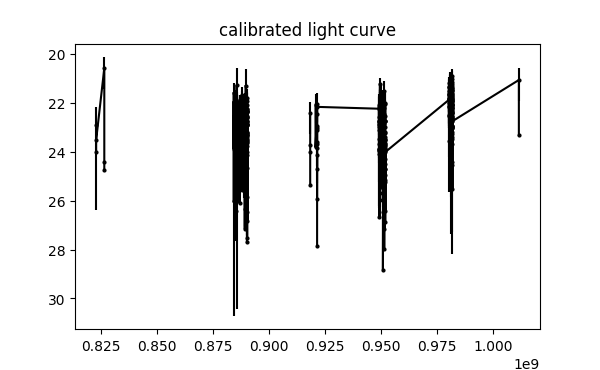

In [27]:
fig2, ax2 = vutils.nb_fig(num=f"{transient}_lc", gr_size=6)
ax2.errorbar(
    lc_data[sel]["t_mean"],
    lc_data[sel]["mag_bgsub"],
    yerr=[lc_data[sel]["mag_bgsub_err_1"], lc_data[sel]["mag_bgsub_err_2"]],
    color="k",
    marker="o",
    ms=2
)
ax2.set_title("calibrated light curve")
ax2.invert_yaxis()